In [48]:
# Analysis of the data. 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper
import pandas as pd
import os
import glob
import shutil
from pathlib import Path
from os import listdir
from os.path import isfile, join

In [2]:
# Import dataset summary and metadata.

dir_summary = Path("data")
fileName = 'Chest_xray_Corona_dataset_Summary.csv'
%time data_summary = pd.read_csv(dir_summary / fileName)
data_summary = data_summary.iloc[:,1:] # delete first column
print(fileName, ' imported')

fileName = 'Chest_xray_Corona_Metadata.csv'
%time metadata = pd.read_csv(dir_summary / fileName)
metadata = metadata.iloc[:,1:] # delete first column
metadata = metadata.fillna("")
print(fileName, ' imported')
metadata['folder'] = ""

# indicate a folder to each image
for i in range(0,len(metadata)) :
    if metadata.iloc[i,3] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4] + "-" +  metadata.iloc[i,3]
    elif metadata.iloc[i,4] != "":
        metadata.iloc[i,5] =  metadata.iloc[i,1] + "-" +  metadata.iloc[i,4]
    else:
        metadata.iloc[i,5] =  metadata.iloc[i,1]

Wall time: 2.02 ms
Chest_xray_Corona_dataset_Summary.csv  imported
Wall time: 148 ms
Chest_xray_Corona_Metadata.csv  imported


In [ ]:
## Move images to train folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/train"
dest_folder = "data/train" # + variavel
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in images:
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
#         if 'Pnemonia-Virus-COVID-19' == metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

In [9]:
## Move images to test folder ##

# Get images names
src_folder = "data/Coronahack-Chest-XRay-Dataset/test"
dest_folder = "data/test" # + variavel
images = [f for f in listdir(src_folder) if isfile(join(src_folder, f))]
# Save each image in its corresponding class directory
counter = 0
for f in images:
    if metadata.loc[metadata['X_ray_image_name'] == f].shape[0] > 0:
#         if 'Pnemonia-Virus-COVID-19' == metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]:
        class_folder = metadata.loc[metadata['X_ray_image_name'] == f, 'folder' ].to_list()[0]
        shutil.copy(os.path.join(src_folder, f), os.path.join(dest_folder, class_folder))
        counter += 1

print("archives: ", counter)

archives:  624


In [2]:
# compose transforms
editions = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(256),
                                 transforms.ToTensor()])
train_data =  datasets.ImageFolder('data/train', transform=editions) # create the ImageFolder
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True) # use the ImageFolder dataset to create the DataLoader
test_data =  datasets.ImageFolder('data/test', transform=editions) # create the ImageFolder
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True) 

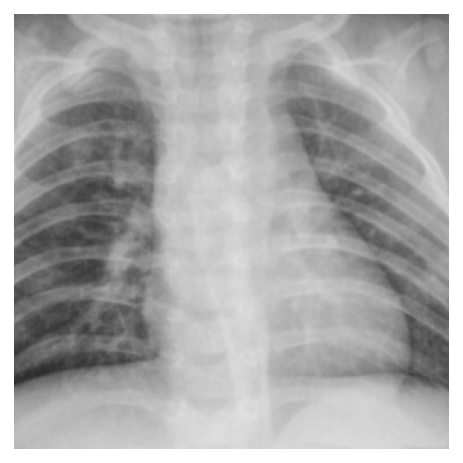

In [3]:
# test data loader
images, labels = next(iter(train_loader))
helper.imshow(images[0], normalize=False)

In [7]:
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 256, 256])
torch.Size([32])


In [28]:
t = torch.rand(32, 3, 256, 256)
b = t.view(t.shape[0], -1)

In [29]:
b.shape

torch.Size([32, 196608])

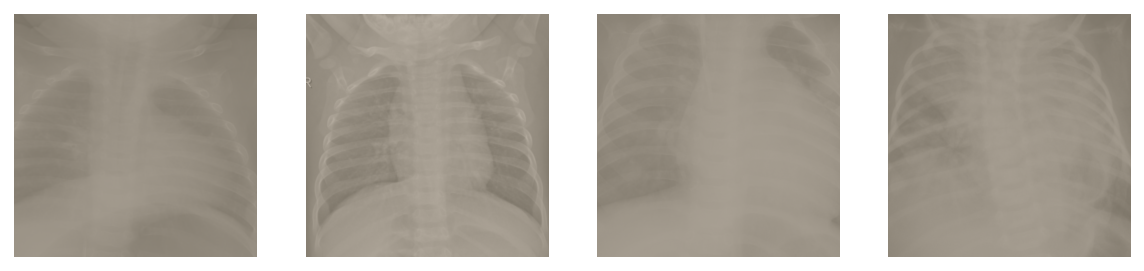

In [13]:
# change this to the trainloader or testloader 
data_iter = iter(train_loader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax)

In [34]:
from torch import nn, optim
import torch.nn.functional as F

# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(196608, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 7)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # ensure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.log_softmax(self.fc4(x), dim=1))
        
        return x

In [35]:
# Create the network, define the criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [37]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Training loss: 4.038310448089278
Training loss: 0.712353160223329
Training loss: 0.7334805621081087
Training loss: 0.6834413352680494
Training loss: 0.6918741404471627
Training loss: 0.6815388046474342
Training loss: 0.653365516518972
Training loss: 0.6416445753301483
Training loss: 0.6373014814523329
Training loss: 0.6303596631231079


In [ ]:
# check overfitting and optimum number of epochs. 
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [73]:
def view_classify_covid_19(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 256, 256).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(1,8), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1,8))
    ax2.set_yticklabels(np.arange(1,8))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

tensor(2)


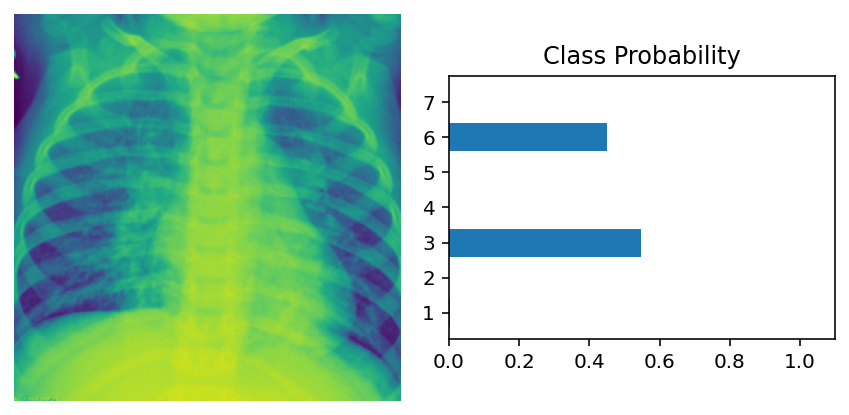

In [74]:
# Test network
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[1]
img_sq = img.view(1, 196608)
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

view_classify_covid_19(img.view(3, 256, 256), ps)
print(labels[1])